CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [5]:
# import numpy as np
# train_mean = 0
# test_mean = 0
# for image,label in train_data:
#   train_mean+= np.mean((image - image.min())/ ((image.max()-image.min())))

# for image,label in test_data:
#   test_mean+= np.mean((image - image.min())/ ((image.max()-image.min())))

CODE BLOCK: 5

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

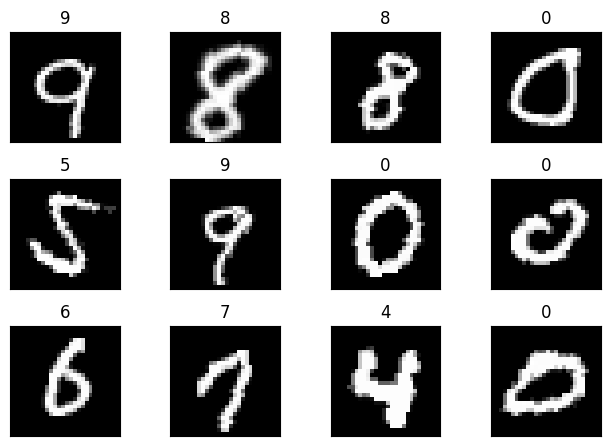

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [10]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
  
    optimizer.zero_grad()
    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()


    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 10

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
# New Line
criterion = nn.NLLLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3563 Batch_id=117 Accuracy=61.64: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Test set: Average loss: 0.0005, Accuracy: 54895/60000 (91.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1184 Batch_id=117 Accuracy=94.32: 100%|██████████| 118/118 [00:13<00:00,  8.83it/s]


Test set: Average loss: 0.0003, Accuracy: 57547/60000 (95.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1736 Batch_id=117 Accuracy=96.18: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Test set: Average loss: 0.0002, Accuracy: 57951/60000 (96.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0210 Batch_id=117 Accuracy=97.05: 100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Test set: Average loss: 0.0002, Accuracy: 58422/60000 (97.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0658 Batch_id=117 Accuracy=97.41: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]


Test set: Average loss: 0.0001, Accuracy: 58585/60000 (97.64%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1480 Batch_id=117 Accuracy=97.73: 100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Test set: Average loss: 0.0001, Accuracy: 58617/60000 (97.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1189 Batch_id=117 Accuracy=97.99: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Test set: Average loss: 0.0001, Accuracy: 58754/60000 (97.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0577 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Test set: Average loss: 0.0001, Accuracy: 58937/60000 (98.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0282 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Test set: Average loss: 0.0001, Accuracy: 58837/60000 (98.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0450 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Test set: Average loss: 0.0001, Accuracy: 59160/60000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0142 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:13<00:00,  8.97it/s]


Test set: Average loss: 0.0001, Accuracy: 59295/60000 (98.83%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0096 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Test set: Average loss: 0.0001, Accuracy: 59303/60000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0272 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0001, Accuracy: 59307/60000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0091 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Test set: Average loss: 0.0001, Accuracy: 59282/60000 (98.80%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0307 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:12<00:00,  9.16it/s]


Test set: Average loss: 0.0001, Accuracy: 59337/60000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0082 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]


Test set: Average loss: 0.0001, Accuracy: 59293/60000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0167 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Test set: Average loss: 0.0001, Accuracy: 59342/60000 (98.90%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0079 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Test set: Average loss: 0.0001, Accuracy: 59352/60000 (98.92%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0055 Batch_id=117 Accuracy=98.90: 100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Test set: Average loss: 0.0001, Accuracy: 59363/60000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0509 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:13<00:00,  9.08it/s]


Test set: Average loss: 0.0001, Accuracy: 59356/60000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-04.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

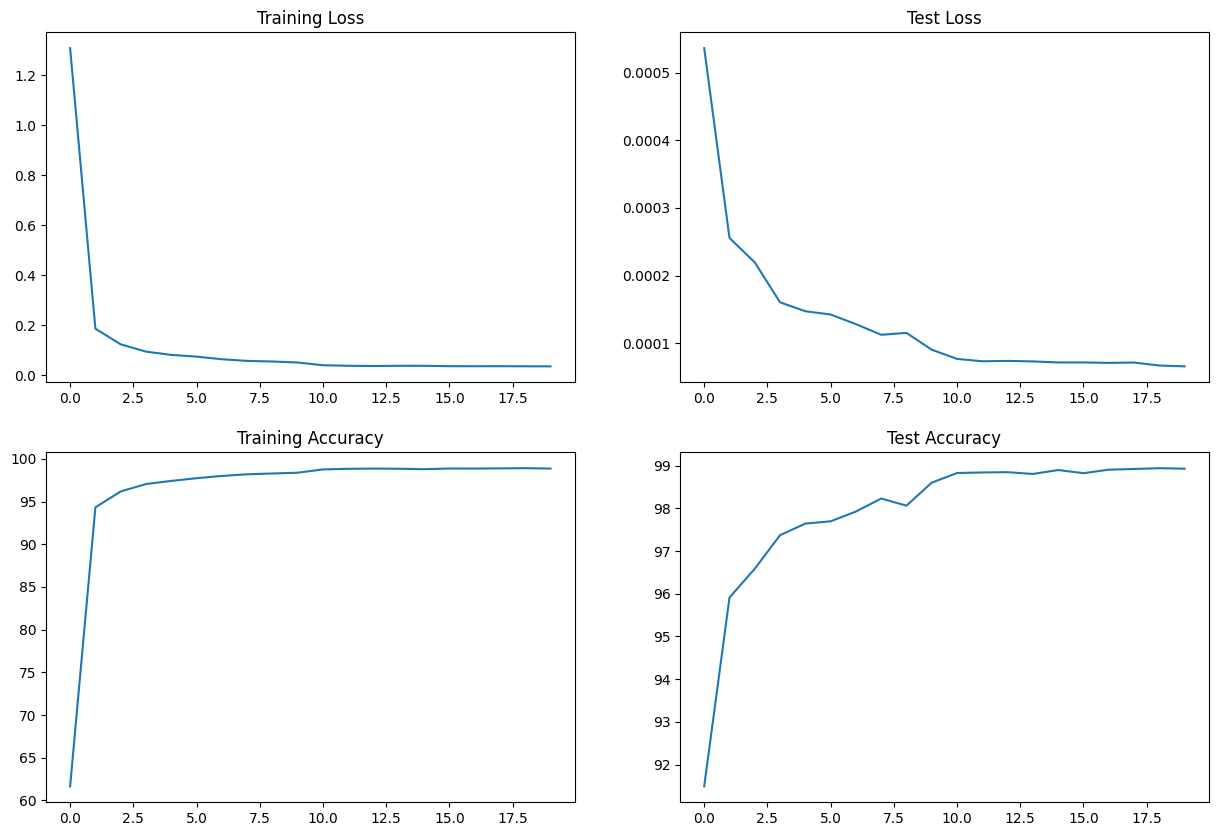

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")